## 1.实验教程

### 1.1 实验背景介绍
LeNet5 + MNIST 被誉为深度学习领域的 “Hello world”。本教程主要介绍使用 paddlepaddle 在 MNIST 手写数字数据集上开发和训练一个 LeNet5 模型，并验证模型精度。
通过以上学习，使用 paddlepaddle 深度学习框架完成对10种动物进行分类。

### 1.2  实验示例：手写数字识别


![](https://ai-studio-static-online.cdn.bcebos.com/4c7206c4ba444963981b43118627fcbf1e67f94840d144bfb7b00265cf63dcfd)

In [12]:
#导入需要的包
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os
from paddle.fluid.dygraph import Linear
print("本教程基于Paddle的版本号为:"+paddle.__version__)

本教程基于Paddle的版本号为:2.0.2


#### **Step1：准备数据。**

(1)数据集介绍

MNIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)transform函数是定义了一个归一化标准化的标准

(3)train_dataset和test_dataset

paddle.vision.datasets.MNIST()中的mode='train'和mode='test'分别用于获取mnist训练集和测试集

transform=transform参数则为归一化标准


In [13]:
# 导入数据集Compose的作用是将用于数据集预处理的接口以列表的方式进行组合。
# 导入数据集Normalize的作用是图像归一化处理，支持两种方式： 1. 用统一的均值和标准差值对图像的每个通道进行归一化处理； 2. 对每个通道指定不同的均值和标准差值进行归一化处理。
from paddle.vision.transforms import Compose, Normalize
transform = Compose([Normalize(mean=[127.5],std=[127.5],data_format='CHW')])
# 使用transform对数据集做归一化
print('下载并加载训练数据')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('加载完成')

下载并加载训练数据
加载完成


AxesImage(25,22;155x154)
train_data0 的标签为: [5]


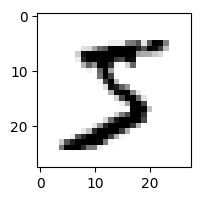

In [14]:
#看看数据集中的图片是什么样子的
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
print(plt.imshow(train_data0, cmap=plt.cm.binary))
print('train_data0 的标签为: ' + str(train_label_0))

#### **Step2.网络配置**
以下的代码定义一个简单的多层感知器，一共有三层，两个shape为[100,100]的隐藏层和shape为[100,10]的输出层，因为MNIST数据集是手写0到9的灰度图像，类别有10个，所以最后的输出维度是10。激活函数是Softmax。多层感知器的结构是：输入层-->>隐藏层-->>隐藏层-->>输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/cb69f928778c4299b75814179607a89eea770bdc409d4e08a87e2975cb96b19b)

In [15]:
# 定义多层感知器 
# 动态图定义多层感知器
class mnist(paddle.nn.Layer):
    def __init__(self):
        super(mnist,self).__init__()
        self.fc1 = paddle.fluid.dygraph.Linear(input_dim=28*28, output_dim=100, act='relu')
        self.fc2 = paddle.fluid.dygraph.Linear(input_dim=100, output_dim=100, act='relu')
        self.fc3 = paddle.fluid.dygraph.Linear(input_dim=100, output_dim=10,act="softmax")

    def forward(self, input_):
        x = fluid.layers.reshape(input_, [input_.shape[0], -1])
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(x)
        return y

In [17]:
from paddle.metric import Accuracy

# 用Model封装模型
model = paddle.Model(mnist())   

# 定义损失函数
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# 配置模型
model.prepare(optim,paddle.nn.CrossEntropyLoss(),Accuracy())

# 训练保存并验证模型
model.fit(train_dataset,test_dataset,epochs=2,batch_size=64,save_dir='multilayer_perceptron',verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/2
step 938/938 [==============================] - loss: 1.5757 - acc: 0.7897 - 13ms/step          
save checkpoint at /home/aistudio/multilayer_perceptron/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 1.4796 - acc: 0.9185 - 12ms/step          
Eval samples: 10000
Epoch 2/2
step 938/938 [==============================] - loss: 1.5322 - acc: 0.9281 - 12ms/step          
save checkpoint at /home/aistudio/multilayer_perceptron/1
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 1.5252 - acc: 0.9461 - 12ms/step          
Eval samples: 10000
save checkpoint at /home/aistudio/multilayer_perceptron/final


 #### **Step3.模型训练及评估**

AxesImage(25,22;155x154)
test_data0 的标签为: [7]
Predict begin...
step 10000/10000 [==============================] - 2ms/step          
Predict samples: 10000
test_data0 预测的数值为：7


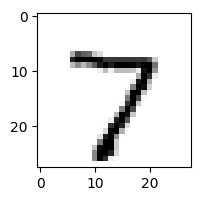

In [18]:
#获取测试集的第一个图片
test_data0, test_label_0 = test_dataset[0][0],test_dataset[0][1]
test_data0 = test_data0.reshape([28,28])
plt.figure(figsize=(2,2))
#展示测试集中的第一个图片
print(plt.imshow(test_data0, cmap=plt.cm.binary))
print('test_data0 的标签为: ' + str(test_label_0))
#模型预测
result = model.predict(test_dataset, batch_size=1)
#打印模型预测的结果
print('test_data0 预测的数值为：%d' % np.argsort(result[0][0])[0][-1])

以上部分仅为教程, 如果运行，那么可以在运行完之后删除multilayer_perceptron文件夹

## 2  实验介绍

### 2.1 任务介绍：动物识别

完成动物分类任务，将根据任务完成的情况给分。\
助教已经构建好了一个简单的卷积神经网络和训练流程，这是代码中已经实现的部分，你可以在这基础上进行改进。\
以下是对于改进的一些提示：

1.采用数据增强，对输入图片进行裁剪或者旋转等来提高性能。\
\
2.改变网络结构，比如增加卷积层数，或使用vgg等复杂网络的结构。\
(注意：不要采用任何的预训练模型，并且复杂的网络有过拟合的风险。当网络结构变化时，超参有可能需要重新调整)\
\
3.可自由发挥，提示 : 引入半监督（伪标签）、vision transformer(VIT)等。

数据集work/data/animal1/semi/目录下是无标签的数据，可利用其产生伪标签从而完成自监督。\
半监督参考资料：\
https://www.bilibili.com/video/BV1Ht411g7Ef?p=23 \
https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf \
vision transformer资料：\
https://aistudio.baidu.com/aistudio/projectdetail/1469534 \
https://zhuanlan.zhihu.com/p/370979971 \
鼓励同学们自由发挥，助教给分会更多考虑代码逻辑和完整性。




### 2.2 实验介绍：
给出的基础代码中实现了对于输入的图片采用卷积神经网络提取特征，再经过全连接后实现图片分类。如下图所示。
![](cnn.png)



### 2.3  实验要求
机器学习一般可以概括为：从数据出发，选择某种模型，通过优化算法更新模型的参数值，使任务的指标表现变好（学习目标），最终学习到“好”的模型，并运用模型对数据做预测以完成任务。由此可见，机器学习方法有四个要素：数据、模型、学习目标、优化算法。本次实验要求熟悉深度学习的一般过程，可搭建简单的神经网络，对数据进行增强以提升分类效果。

### 2.4 实验环境
基于paddle2.0.2，Python=3.7

## 3 实验内容

### 3.1 准备数据集
训练前需要先解压数据文件，并删除一些.zip文件。如果提示文件夹不存在，则建立相应目录再执行命令。
* 训练集
* 验证集
* 公开测试集
* 私有测试集（无标注）
* semi数据集（用于半监督，无标注）


对于训练集、验证集和测试集，图片所属于的文件夹就是图像的标签。\
你可以自行使用验证集和公开测试集来检验自己模型的效果，助教保留了私有测试集的标注来评估模型。你的模型需要在私有测试集上进行预测，并将预测结果输出到csv文件中，我们将根据预测结果对提交的模型效果进行评分。


In [13]:
#如果提示文件夹不存在，则在work下新建work/data/animal后再解压
import os
if not os.path.exists('work/data/animal'):
    os.makedirs('work/data/animal')
    !unzip data/data265169/animal.zip -d work/data/animal/

  inflating: work/data/animal/pub_test/1/sheep_10232.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10233.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10234.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10235.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10236.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10237.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10238.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10239.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10240.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10241.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10242.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10243.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10244.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10245.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10246.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10247.jpg  
  inflating: work/data/animal/pub_test/1/sheep_10248.jpg

### 3.2 导入相关包

In [4]:
#导入包
import numpy as np
import os
import paddle
from paddle.io import Dataset, DataLoader
import paddle.nn as nn
import paddle.nn.functional as F
# import paddle.fluid as fluid
from paddle.vision.datasets import DatasetFolder
import paddle.vision.transforms as transforms
from PIL import Image
import sys
import warnings
import bisect
import math
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### 3.3 数据处理
paddle.vision 为图像预处理、数据包装以及数据增强提供了许多有用的实用程序。

在这里，由于我们的数据是按类标签存储在文件夹中的，所以我们可以直接应用 paddle.vision.datasets.DatasetFolder 来包装数据。

详细信息，请参阅 paddlepaddle 官网。

你需要完成数据增强部分的代码。如对图片进行旋转或者缩放、裁剪等操作。

In [5]:
# 在训练中进行数据增强很重要。
train_tfm = transforms.Compose([
    # 将图像大小调整为固定形状 (height = width = 128)
    transforms.Resize((128, 128)),
    # ---------- TODO ----------
    # 在此处添加你的代码
    transforms.ColorJitter(0.2, 0.2),
    # transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])


# 我们不需要在测试和验证中进行扩充。
# 只需要调整 PIL 图像的大小并将其转换为 Tensor。
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [6]:
import os

#此处代码为构造dataloader函数。
IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG",
    ".png", ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def default_loader(path):
    return Image.open(path).convert("RGB")
    

def make_dataset(root, split, txtfile=None):
    images = []
    if txtfile is not None:
        ordertxt = open(txtfile)
        for line in ordertxt:
            data = line.strip()
            if is_image_file(data):
                imgpath = os.path.join(root,split,data)
            item = (imgpath, -1)
            images.append(item)
    else:
        root=os.path.join(root, split)
        for onelabel in os.listdir(root):
            newdir=os.path.join(root, onelabel)
            for img in os.listdir(newdir):
                imgpath=os.path.join(newdir,img)
                item = (imgpath, int(onelabel))
                images.append(item)
    return images

class ImageSet(Dataset):
    def __init__(self, root,split, transform=None, loader=default_loader,txtfile=None):
        self.samples = make_dataset(root,split,txtfile)
        self.root = root
        self.txtfile = txtfile
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, gt = self.samples[index]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)
        return img, gt

    def __len__(self):
        return len(self.samples)


In [7]:
# 更大的batch size通常会提供更稳定的梯度，但是GPU 显存是有限的，batch size过大，显存可能加载不了。
batch_size = 256
# 如果 out of memory,可以调小batch_size或者选用显存更大的GPU

# 构建数据集。数据集划分为训练集、验证集、公开测试集和私有测试集。私有测试集的标签在助教手中，助教将依据您对私有测试集的预测结果来打分。
# 代码main.ipynb要求一并上交，所以在实验报告中请如实作答。
    
data_root = 'work/data/animal/'
train_set = ImageSet(data_root,split="train", loader=lambda x: Image.open(x),transform=train_tfm)
val_set = ImageSet(data_root,split="val", loader=lambda x: Image.open(x), transform=test_tfm)
pub_test_set = ImageSet(data_root,split="pub_test", loader=lambda x: Image.open(x), transform=test_tfm)
pri_test_set = ImageSet(data_root,split="pri_test",txtfile="pri_test_only_name.txt",loader=lambda x: Image.open(x), transform=test_tfm)
semi_set = ImageSet(data_root,split="semi",txtfile="semi_only_name.txt",loader=lambda x: Image.open(x), transform=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
pub_test_loader = DataLoader(pub_test_set, batch_size=batch_size, shuffle=False, drop_last=False)
pri_test_loader = DataLoader(pri_test_set, batch_size=batch_size, shuffle=False, drop_last=False)


### 3.4 模型
### 3.4.1 CNN基础模型
基本模型由卷积层和全连接层构成。

由于彩色图像 (RGB) 有三个通道，因此网络的输入通道必须是3。输入大小为（3，128，128）。（128，128）为图片的宽和高。\
卷积网络的实现可调用nn.Conv2D（）函数，具体输入的参数请参数paddle使用文档。\
nn.MaxPool2D()可对图片进行最大池化以提取重要特征。\
在输入全连接层之前，必须将特征图展平。经过全连接层，最后获得每个类的“logits”。


您可以在此处自由修改模型架构，以进一步提升效果。\
\
注意事项：
使用互联网上任何模型都是允许的，但是，如果想使用常见的网络结构，如vgg等，请确保不要加载预训练的参数。\
另外，复杂的网络有过拟合的风险，当改变网络结构时，超参也有可能需要调整。\
\
例如，如果您使用 ResNet-18 作为模型：

model = paddle.vision.models.resnet18(pretrained=False) → 这是符合要求。

model = paddle.models.resnet18(pretrained=True) → 这是不符合要求的

In [8]:
class CNN(nn.Layer):
    def __init__(self):
        super(CNN, self).__init__()
        # 常用模块的参数：
        # paddle.nn.Conv2D(in_channels, out_channels, kernel_size, stride, padding)
        # paddle.nn.MaxPool2D(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2D(3, 64, 3, 1, 1),
            nn.GELU(),
            nn.MaxPool2D(2, 2, 0),

            nn.Conv2D(64, 128, 3, 1, 1),
            nn.GELU(),
            nn.MaxPool2D(2, 2, 0),

            nn.Conv2D(128, 256, 3, 1, 1),
            nn.GELU(),

            nn.Conv2D(256, 256, 3, 1, 1),
            nn.GELU(),
            nn.MaxPool2D(2, 2, 0),

            nn.Conv2D(256, 512, 3, 1, 1),
            nn.GELU(),
            nn.MaxPool2D(2, 2, 0),


            nn.Conv2D(512, 1024, 3, 1, 1),
            nn.GELU(),
            nn.MaxPool2D(4, 4, 0),
        )
        # self.res_layers = nn.Sequential(
        #     nn.Conv2D(256, 1024, 1, 1),
        #     # nn.BatchNorm2D(1024),
        #     nn.ReLU(),
        #     nn.MaxPool2D(2, 2, 0),
        # )
        # self.cnncon_layers = nn.Sequential(

        #     nn.Conv2D(256, 512, 3, 1, 1),
        #     nn.GELU(),
            

        #     nn.Conv2D(512, 1024, 3, 1, 1),
        #     # nn.BatchNorm2D(1024),
        #     nn.ReLU(),
        #     nn.MaxPool2D(2, 2, 0),
        #     # nn.MaxPool2D(4, 4, 0),
        # )
        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 1024),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 10]

        # 提取特征
        x = self.cnn_layers(x)
        x = x.flatten(1)
        # 特征通过全连接层转换得到最终的logits。
        x = self.fc_layers(x)
        return x
    # ---------- TODO ----------
    #在此处自由修改模型架构以进行进一步改进。如增加卷积层数等。
    #如果您想使用一些众所周知的架构，例如 ResNet50，请确保不要加载预训练的权重。另外，复杂的模型有过拟合的风险。
    


### 3.4.2 VisionTransformer模型
VisionTransformer模型总体上由 PatchEmbed层 , depth 个堆叠的 自注意力Block 和最后的 分类头 组成。\
如果你想尝试使用VisionTransformer来达到更好的效果，助教已经帮你实现好了整个VisionTransformer \
但是你还需要探索一组合适的参数用于VisionTransformer.__init__，有一定的难度，建议最后尝试。


In [6]:
# 参数初始化配置
trunc_normal_ = nn.initializer.TruncatedNormal(std=.02)
zeros_ = nn.initializer.Constant(value=0.)
ones_ = nn.initializer.Constant(value=1.)


from ViT import Identity, PatchEmbed, Block
class VisionTransformer(nn.Layer):
    def __init__(self,
                 img_size=128,
                 patch_size=16,
                 in_chans=3,
                 class_dim=10,
                 embed_dim=768,
                 depth=4,
                 num_heads=4,
                 mlp_ratio=4,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 norm_layer='nn.LayerNorm',
                 epsilon=1e-5,
                 **args):
        super().__init__()
        self.class_dim = class_dim

        self.num_features = self.embed_dim = embed_dim
        # 图片分块和降维，块大小为patch_size，最终块向量维度为768
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        # 分块数量
        num_patches = self.patch_embed.num_patches
        # 可学习的位置编码
        self.pos_embed = self.create_parameter(shape=(1, num_patches + 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)
        # 人为追加class token，并使用该向量进行分类预测
        self.cls_token = self.create_parameter(shape=(1, 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = np.linspace(0, drop_path_rate, depth)
        # transformer
        self.blocks = nn.LayerList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
                epsilon=epsilon) for i in range(depth)
        ])

        self.norm = eval(norm_layer)(embed_dim, epsilon=epsilon)

        # Classifier head
        self.head = nn.Linear(embed_dim,class_dim) if class_dim > 0 else Identity()

        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        self.apply(self._init_weights)
    # 参数初始化
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            zeros_(m.bias)
            ones_(m.weight)

    def forward_features(self, x):

        B = paddle.shape(x)[0]
        # 将图片分块，并调整每个块向量的维度
        x = self.patch_embed(x)

        # 将class token与前面的分块进行拼接
        cls_tokens = self.cls_token.expand((B, -1, -1))
        x = paddle.concat((cls_tokens, x), axis=1)
        # 将编码向量中加入位置编码
        x = x + self.pos_embed
        x = self.pos_drop(x)
        # 堆叠 transformer 结构
        for blk in self.blocks:
            x = blk(x)
        # LayerNorm
        x = self.norm(x)
        # 提取分类 tokens 的输出
        return x[:, 0]

    def forward(self, x):
        # 获取图像特征
        x = self.forward_features(x)
        # 图像分类
        x = self.head(x)
        return x

### 3.5 训练
## 一些性能相关的提示
1 基于最基础的代码，不增加任何数据增强，不修改任何参数，batch_size = 256 跑通，训练10个epoch， best_val_acc大约 0.508\
2 数据增强+修改提供的CNN网络结构+调整学习率，训练35epoch  best_val_acc大约 0.72-0.73 \
3 数据增强+修改提供的CNN网络结构+调整学习率+半监督数据集  性能微量up \
4 尝试使用VIT或者更适合小数据集的VIT变体？ 自由探索！\
5 推荐将模型训练到一定的效果后再考虑半监督，不然会误导模型

In [6]:
# 固定 random seed
def same_seeds(seed):
    paddle.seed(seed)
    np.random.seed(seed)

same_seeds(0)
do_semi = False
init_model=True

继续训练模型请运行以下单元格

In [7]:
init_model=False
do_semi=False
model = CNN()
state_dict = paddle.load(os.path.join('work/model/best_model.pdparams'))
model.set_state_dict(state_dict)
best_acc=0.7241051077842713
loss_record = {'train': {'loss': [], 'iter': []}, 'val': {'loss': [], 'iter': []}}   # for recording loss
acc_record = {'train': {'acc': [], 'iter': []}, 'val': {'acc': [], 'iter': []}}      # for recording accuracy
loss_iter = 0
acc_iter = 0

In [11]:
n_epochs = 10
learning_rate = 0.0001
work_path = 'work/model'

if do_semi:
    this_train_loader = semi_train_loader
    print("do_semi")
else:
    this_train_loader = train_loader

# 加载模型 开始训练
if init_model:
    val_acc = 0.0
    best_acc = 0.0

    #初始化模型
    model=CNN()
    # model = VisionTransformer()

    # 初始化优化器，可以微调一些超参数，比如学习率。
grad_norm = paddle.nn.ClipGradByGlobalNorm(clip_norm=10)
optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=learning_rate, weight_decay=1e-3, grad_clip=grad_norm)
    
loss_iter = 0
acc_iter = 0
loss_record = {'train': {'loss': [], 'iter': []}, 'val': {'loss': [], 'iter': []}}   # for recording loss
acc_record = {'train': {'acc': [], 'iter': []}, 'val': {'acc': [], 'iter': []}}      # for recording accuracy
# 损失函数cross-entropy
criterion = nn.CrossEntropyLoss()

import paddle.metric
print("start train")
for epoch in range(n_epochs):
    model.train()
    train_num = 0.0
    train_loss = 0.0
    val_num = 0.0
    val_loss = 0.0
    accuracy_manager = paddle.metric.Accuracy()
    val_accuracy_manager = paddle.metric.Accuracy()

    for batch_id, data in enumerate(this_train_loader):
        x_data, y_data = data

        if y_data.dim()==1:
            y_data = paddle.unsqueeze(y_data, axis=1)
        logits = model(x_data)
        # print("43_y_data.shape",y_data.shape)
        loss = criterion(logits, y_data)
        acc = paddle.metric.accuracy(logits, y_data)
        accuracy_manager.update(acc)
        if batch_id % 10 == 0:
            loss_record['train']['loss'].append(loss.numpy())
            loss_record['train']['iter'].append(loss_iter)
            loss_iter += 1
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        train_loss += loss
        train_num += len(y_data)

    
    total_train_loss = (train_loss / train_num) * batch_size
    train_acc = accuracy_manager.accumulate()
    acc_record['train']['acc'].append(train_acc)
    acc_record['train']['iter'].append(acc_iter)
    acc_iter += 1
    print("#===epoch: {}, train loss is: {}, train acc is: {:2.2f}%===#".format(epoch, total_train_loss.numpy(), train_acc*100))

    # ---------- Validation ----------
    # 确保模型处于value模式，以便某些仅仅适用于训练的操作（如 dropout）被禁用并正常工作。
    model.eval()

    # 分批迭代验证集。
    for batch_id, data in enumerate(val_loader):
        # 一个batch由图像数据和相应的标签组成。
        x_data, y_data = data
        
        if y_data.dim()==1:
            y_data = paddle.unsqueeze(y_data, axis=1)
        with paddle.no_grad():
          logits = model(x_data)
        loss = criterion(logits, y_data)
        # 计算每个batch的 the accuracy 
        acc = paddle.metric.accuracy(logits, y_data)
        val_accuracy_manager.update(acc)
        # 记录 loss and accuracy.
        val_loss += loss
        val_num += len(y_data)

    
    total_val_loss = (val_loss / val_num) * batch_size
    loss_record['val']['loss'].append(total_val_loss.numpy())
    loss_record['val']['iter'].append(loss_iter)
    val_acc = val_accuracy_manager.accumulate()
    acc_record['val']['acc'].append(val_acc)
    acc_record['val']['iter'].append(acc_iter)
    print("#===epoch: {}, val loss is: {}, val acc is: {:2.2f}%===#".format(epoch, total_val_loss.numpy(), val_acc*100))
    # ===================save====================
    if val_acc > best_acc:
        best_acc = val_acc
        paddle.save(model.state_dict(), os.path.join(work_path, 'best_model.pdparams'))
        paddle.save(optimizer.state_dict(), os.path.join(work_path, 'best_optimizer.pdopt'))
        print(f"saved,best_val_acc={best_acc}")


paddle.save(model.state_dict(), os.path.join(work_path, 'final_model.pdparams'))
paddle.save(optimizer.state_dict(), os.path.join(work_path, 'final_optimizer.pdopt'))

do_semi
start train
epoch: 0, batch_id: 0, loss is: 0.14970673620700836, acc is: 0.95703125
#===epoch: 0, train loss is: 0.1617727428674698, train acc is: 94.88%===#
#===epoch: 0, val loss is: 0.8715041875839233, val acc is: 76.85%===#
saved,best_val_acc=0.7684943199157714
epoch: 1, batch_id: 0, loss is: 0.07856926321983337, acc is: 0.984375
#===epoch: 1, train loss is: 0.09112608432769775, train acc is: 98.34%===#
#===epoch: 1, val loss is: 0.8951197266578674, val acc is: 75.58%===#
epoch: 2, batch_id: 0, loss is: 0.0702250525355339, acc is: 0.9765625
#===epoch: 2, train loss is: 0.06632110476493835, train acc is: 98.29%===#
#===epoch: 2, val loss is: 0.9455882906913757, val acc is: 74.87%===#
epoch: 3, batch_id: 0, loss is: 0.038740139454603195, acc is: 0.9921875
#===epoch: 3, train loss is: 0.03531450033187866, train acc is: 99.71%===#
#===epoch: 3, val loss is: 0.9965346455574036, val acc is: 75.16%===#
epoch: 4, batch_id: 0, loss is: 0.02972470410168171, acc is: 0.9921875
#===epoc

如果想要更进一步提升效果，需要完成下面的函数“get_pseudo_labels”中空缺的内容。该函数用于半监督学习。 具体而言，需要对未标记的数据进行预测，然后获得置信度大的预测结果作为伪标签来扩充数据集，这样模型会获得更好的表现。

In [9]:
from paddle.io import TensorDataset

def get_pseudo_labels(dataset, model, threshold=0.65):
    # 此函数使用给定模型生成数据集的伪标签。
    # 它返回一个 DatasetFolder 实例，其中包含预测图片logits置信度超过给定阈值的图片。
  
    # 构造一个数据加载器。
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    dataset = []
    # 确保模型处于 eval 模型）禁止训练。
    model.eval()
    # 定义softmax函数
    softmax = nn.Softmax(axis=-1)
    # 训练
    for batch_id, data in enumerate(data_loader):
        batch_img, _ = data
        # 使用 torch.no_grad() 加速了前向过程。
        with paddle.no_grad():
            logits = model(batch_img)

        # 通过对 logits 应用 softmax 来获得概率分布。
        probs = softmax(logits)
        # print(probs.shape)
        # ---------- TODO ----------
        # 过滤数据并构建一个新的数据集。提示：使用TensorDataset
        max_probs, predicts = paddle.topk(probs, k=1, axis=1)  
        filtered_indices = max_probs.squeeze(1) >= threshold  
        filtered_imgs = batch_img[filtered_indices]  
        filtered_labels = predicts[filtered_indices]
        dataset.extend(list(zip(filtered_imgs.numpy(), filtered_labels.numpy())))
        
    dataset = TensorDataset([paddle.to_tensor([x[0] for x in dataset]),paddle.to_tensor([x[1] for x in dataset])])  
        # --------------------------------
    return dataset

In [10]:
# 当你需要进行半监督训练时修改以下的do_semi为True，构建semi_train_loader后，再次运行模型训练单元格（# 加载模型 开始训练单元格）即可
# 注意：使用半监督的前提条件是你的模型已经可以取得一定的效果
# 当你进行半监督训练时，你的模型已经是训练过的，所以,你应该调整相关参数（n_epochs,learning_rate)
do_semi=True
threshold = 0.65
if do_semi:
    # ---------- TODO ----------
    # 使用经过训练的模型获取未标记数据的伪标签（提示：调用get_pseudo_labels函数）。
    best_acc = 0.7539346575736999
    model = CNN()
    state_dict = paddle.load(os.path.join('work/model/best_model.pdparams'))
    model.set_state_dict(state_dict)
    semi_train_dataset=get_pseudo_labels(semi_set, model=model, threshold=threshold)
    # --------------------------------
    # 构造一个新的数据集和一个用于训练的数据加载器。
    semi_train_loader = DataLoader(semi_train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    init_model=False
    # 置init_model为False，确保再次再次运行模型训练单元格时，不会重新初始化模型

In [12]:
#画图
def plot_learning_curve(record, title='loss', ylabel='CE Loss'):
    ''' Plot learning curve of your CNN '''
    maxtrain = max(map(float, record['train'][title]))
    maxval = max(map(float, record['val'][title]))
    ymax = max(maxtrain, maxval) * 1.1
    mintrain = min(map(float, record['train'][title]))
    minval = min(map(float, record['val'][title]))
    ymin = min(mintrain, minval) * 0.9
    total_steps = len(record['train'][title])
    x_1 = list(map(int, record['train']['iter']))
    x_2 = list(map(int, record['val']['iter']))
    figure(figsize=(10, 6))
    plt.plot(x_1, record['train'][title], c='tab:red', label='train')
    plt.plot(x_2, record['val'][title], c='tab:cyan', label='val')
    plt.ylim(ymin, ymax)
    plt.xlabel('Training steps')
    plt.ylabel(ylabel)
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

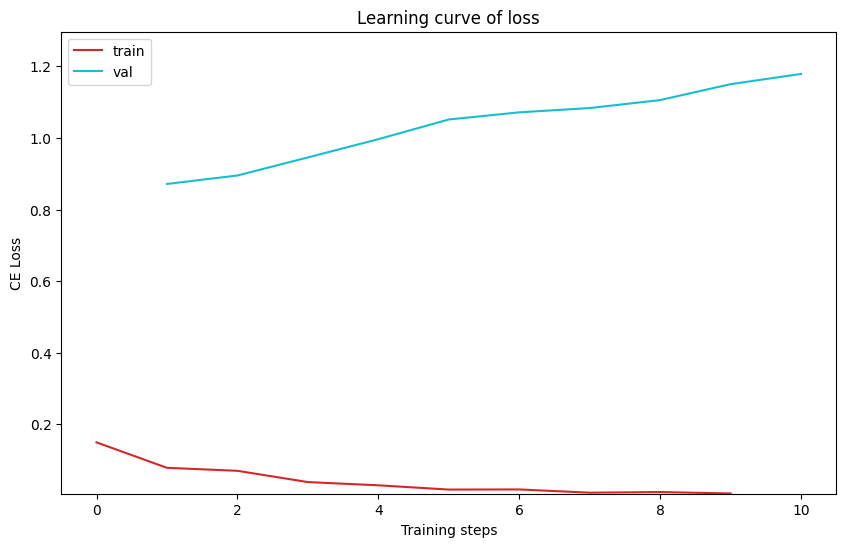

In [13]:
plot_learning_curve(loss_record, title='loss', ylabel='CE Loss')

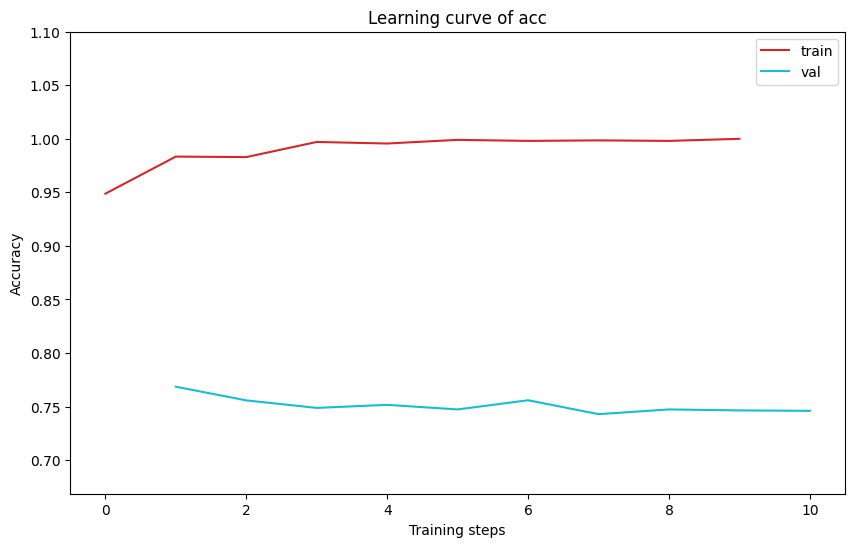

In [14]:
plot_learning_curve(acc_record, title='acc', ylabel='Accuracy')

### 3.5测试和提交
对于测试，我们需要确保模型处于 eval 模式，并且数据集的顺序不应该被打乱（test_loader 中的“shuffle=False”）。

将预测保存到 CSV 文件中。csv文件需要被提交，这是我们测试模型效果的重要依据。

最后上交的文件夹中包括此jupyter文件（后缀为ipynb的文件），预测结果predict.csv文件，以及实验报告和问答题的答案。

In [17]:
# 确保模型处于eval模式。
# 初始化一个列表来存储预测。
predictions = []
model_state_dict = paddle.load(os.path.join(work_path, 'best_model.pdparams'))
# optimizer_state_dict = paddle.load('work/model/best_model.pdopt')
model.set_state_dict(model_state_dict)
# optimizer.set_state_dict(optimizer_state_dict)

test_num = 0.0
test_loss = 0.0

model.eval()
test_accuracy_manager = fuAccuracy()
# 在公开测试集上进行测试
for batch_id, data in enumerate(pub_test_loader):
    x_data, y_data = data
    labels = paddle.unsqueeze(y_data, axis=1)
    
    # ===================forward=====================
    # 在测试中不需要梯度。
    # 使用 paddle.no_grad() 加速前进过程。
    with paddle.no_grad():
        predicts = model(x_data)
        loss = criterion(predicts, y_data)
    # ==================calculate acc================
    acc = paddle.metric.accuracy(predicts, labels)
    test_accuracy_manager.update(value = acc.numpy(), weight = len(y_data))

    test_loss += loss
    test_num += len(y_data)

test_acc = test_accuracy_manager.eval()
total_test_loss = (test_loss / test_num) * batch_size
print("test loss is: {}, test acc is: {}".format(total_test_loss.numpy(), test_acc))




# 在私有测试集上进行测试
for batch_id, data in enumerate(pri_test_loader):
    x_data, y_data = data
    with paddle.no_grad():
        logits = model(x_data)
    predictions.extend(paddle.argmax(logits, axis=1).cpu().numpy().tolist())

# 将私有测试集的预测结果保存到文件predict.csv中
with open("./predict.csv", "w") as f:
    f.write("Id,Category\n")
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


test loss is: 0.9932631254196167, test acc is: 0.7323151140734314


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [16]:
class fuAccuracy():
    def __init__(self, name=None):
        self.value = .0
        self.weight = .0

    def update(self, value, weight):
        self.value += value * weight
        self.weight += weight

    def eval(self):
        if self.weight == 0:
            raise ValueError("There is no data in Accuracy Metrics. \
                Please check layers.accuracy output has added to Accuracy.")
        return self.value / self.weight